In [51]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    mean_squared_error, 
    r2_score
)


plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False


In [ ]:

# ---Parsing the XML file and creating lon-lat mesh ---

def load_and_parse_data(xml_file):
    start_lon, start_lat = 120.00, 21.88
    lon_resolution, lat_resolution = 0.03, 0.03
    lon_count, lat_count = 67, 120
    invalid_value = -999.0

    tree = ET.parse(xml_file)
    root = tree.getroot()
    namespace = {'cwa': 'urn:cwa:gov:tw:cwacommon:0.1'}
    content_str = root.find('.//cwa:Content', namespace).text
    
    raw_values = []
    lines = content_str.strip().split('\n')
    for line in lines:
        values = [float(v) for v in line.strip().split(',') if v.strip()]
        raw_values.extend(values)

    lons = np.arange(lon_count) * lon_resolution + start_lon
    lats = np.arange(lat_count) * lat_resolution + start_lat
    
    grid_points = []
    for lat in lats:
        for lon in lons:
            grid_points.append((lon, lat))
            
    num_expected_points = lon_count * lat_count
    if len(raw_values) != num_expected_points:
        raw_values = (raw_values + [invalid_value] * num_expected_points)[:num_expected_points]

    df = pd.DataFrame(grid_points, columns=['longitude', 'latitude'])
    df['temperature'] = raw_values
    
    print(f"Total: {len(df)} data points\n")
    return df


def create_datasets(base_df):
    # Creating classification dataset
    df_cls = base_df.copy()
    df_cls['label'] = (df_cls['temperature'] != -999.0).astype(int)
    X_cls = df_cls[['longitude', 'latitude']]
    y_cls = df_cls['label']
    print(f"{y_cls.value_counts()}\n")

    # Creating regression dataset
    df_reg = base_df[base_df['temperature'] != -999.0].copy()
    X_reg = df_reg[['longitude', 'latitude']]
    y_reg = df_reg['temperature']
    
    return X_cls, y_cls, X_reg, y_reg




In [53]:

aspect_ratio = 1 / np.cos(np.radians(23.5))


def train_classification_model(X, y):
    print("--- Trainning classification model... ---")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("\n========== Classification model report ==========")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f}\n")

    report = classification_report(y_test, y_pred, target_names=['Invalid (0)', 'Valid (1)'])
    print(report)
    print("=" * 40)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['0', '1'], 
                yticklabels=['0', '1'])
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.show()

    # Geospatial Distribution
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)
    
    # Left: Actual data
    axes[0].scatter(X_test[y_test == 0]['longitude'], X_test[y_test == 0]['latitude'], 
                    c='lightgray', s=1, label='0')
    axes[0].scatter(X_test[y_test == 1]['longitude'], X_test[y_test == 1]['latitude'], 
                    c='blue', s=5, label='1')
    axes[0].set_title('Actual distribution', fontsize=16)
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_aspect(aspect_ratio, adjustable='box') 


    # Right: Predicted data
    axes[1].scatter(X_test[y_pred == 0]['longitude'], X_test[y_pred == 0]['latitude'], 
                    c='lightgray', s=1, label='Predicted 0')
    axes[1].scatter(X_test[y_pred == 1]['longitude'], X_test[y_pred == 1]['latitude'], 
                    c='blue', s=5, label='Predicted 1')
    # Indicate the wrong predictions.
    errors = X_test[y_test != y_pred]
    axes[1].scatter(errors['longitude'], errors['latitude'], 
                    c='red', s=10, marker='x', label='Wrong prediction')
    axes[1].set_title('Model Predicted distribution', fontsize=16)
    axes[1].set_xlabel('Longitude')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_aspect(aspect_ratio, adjustable='box')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



In [54]:

def train_regression_model(X, y):
    print("--- Trainning regression model... ---")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("\n========== Regression model report ==========")
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"MSE       : {mse:.4f}")
    print(f"RMSE     : {rmse:.4f} (Average error for the temperature prediction = {rmse:.2f}°C)")
    print(f"R-squared (R²)        : {r2:.4f}")
    print("=" * 40)

    # Fig 1. Predicted vs. Actual
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs. Actual')
    # draw a line y=x
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal (y=x)')
    plt.title('Predicted vs Actual', fontsize=16)
    plt.xlabel('Actual Temp. (°C)', fontsize=12)
    plt.ylabel('Predicted Temp. (°C)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

    # Geospatial Distribution
    errors = np.abs(y_pred - y_test)
    plt.figure(figsize=(10, 10)) 
    ax = plt.gca()
    scatter = ax.scatter(X_test['longitude'], X_test['latitude'], c=errors, cmap='viridis', s=15, alpha=0.8)
    plt.colorbar(scatter, label='absolute error (°C)', ax=ax, shrink=0.8) 
    ax.set_title('Geospatial Distribution of Absolute Prediction Errors', fontsize=16)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True)
    ax.set_aspect(aspect_ratio, adjustable='box')
    plt.show()



In [55]:
xml_filename = "O-A0038-003.xml"
base_dataframe = load_and_parse_data(xml_filename)

Total: 8040 data points



In [56]:
X_classification, y_classification, X_regression, y_regression = create_datasets(base_dataframe)

label
0    4545
1    3495
Name: count, dtype: int64



--- Trainning classification model... ---

========== Classification model report ==========
Overall Accuracy: 0.9871

              precision    recall  f1-score   support

 Invalid (0)       0.99      0.99      0.99      1363
   Valid (1)       0.99      0.98      0.99      1049

    accuracy                           0.99      2412
   macro avg       0.99      0.99      0.99      2412
weighted avg       0.99      0.99      0.99      2412



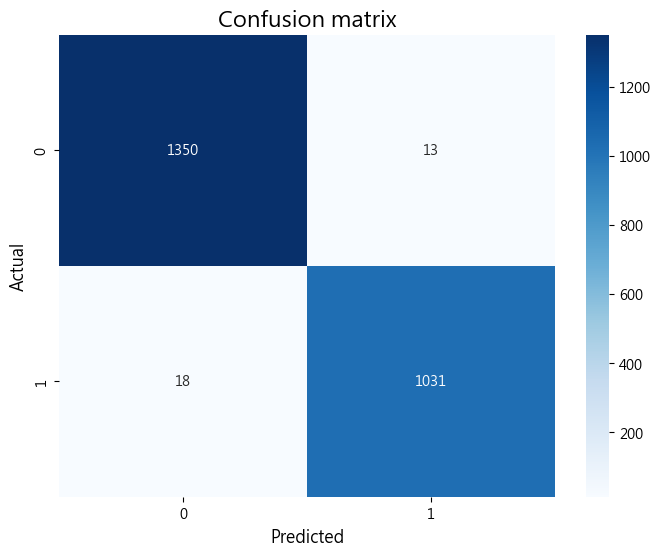

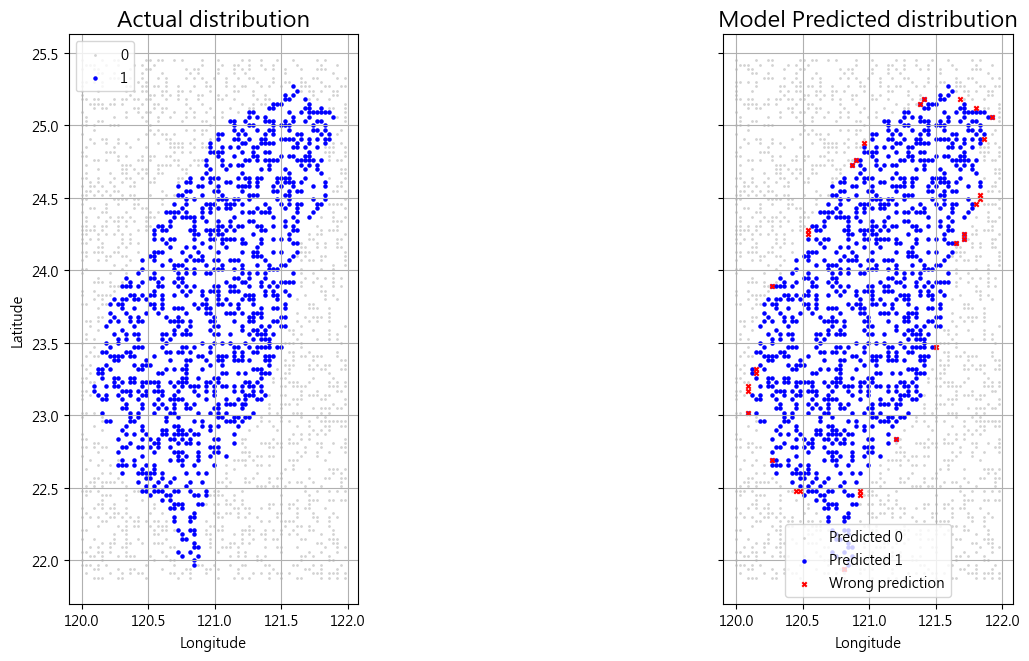

In [57]:
train_classification_model(X_classification, y_classification)
print("\n" + "="*50 + "\n")

--- Trainning regression model... ---

========== Regression model report ==========
MSE       : 5.5247
RMSE     : 2.3505 (Average error for the temperature prediction = 2.35°C)
R-squared (R²)        : 0.8499


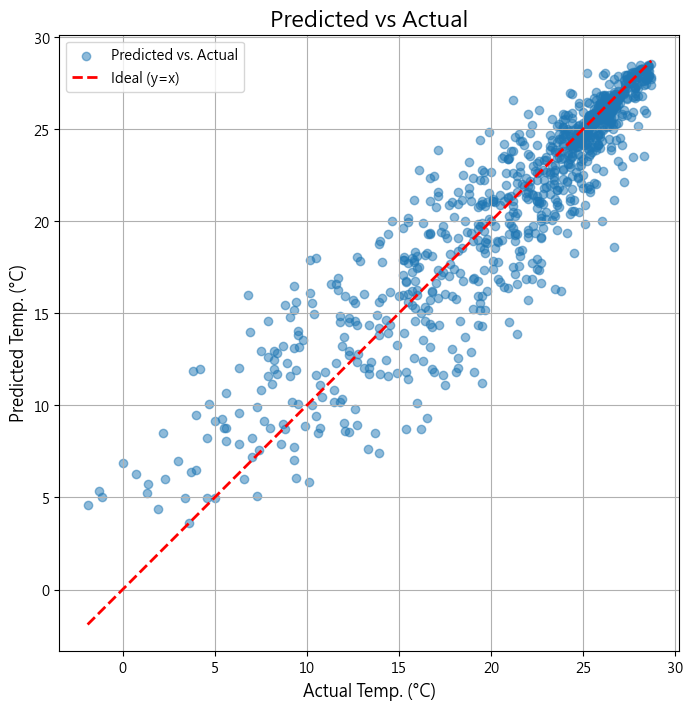

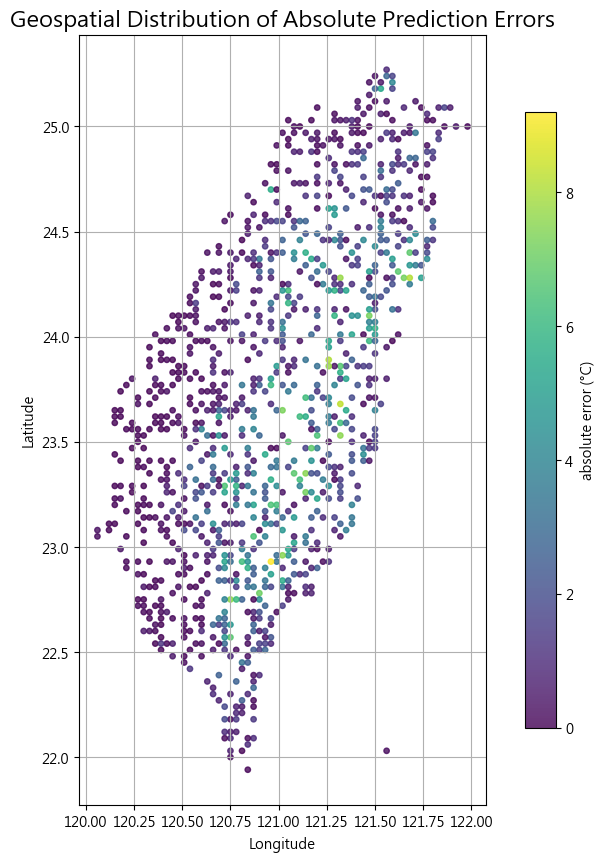

In [58]:
train_regression_model(X_regression, y_regression)